## Import des librairies

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

#Scraping des Tweets
import twint 
import nest_asyncio

#Preprocessing
from unidecode import unidecode
import re,string
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer


#Dataviz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from yellowbrick.cluster import InterclusterDistance

#Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modèles de classification SKLearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

#Modèles de classification Gensim
import gensim,  logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from operator import itemgetter
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

#Logs d'erreurs
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Plots de progression
from tqdm import tqdm 

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\eloue\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nest_asyncio.apply()

# 1.<span style="color:red"> EXTRACTION & COLLECTE DES TWEETS </span>

In [3]:
# Configuration 
#c = twint.Config()
#c.Search ="europeansuperleague OR superleague européene"  #Topic de recherche
#c.Lang = "fr" #langue des Tweets
#c.Store_csv = True #Type de storage
#c.Output = "data/ESL.CSV" #Adresse du storage
#c.Pandas= True #conversion vers df
#c.Since = "2021-04-18" #date de début
#twint.run.Search(c) 

In [4]:
df = pd.read_csv("data/super_league_europeenne16.csv")
df = df.loc[df['language'] == "fr"]
df = df.loc[:, ['date', 'time','tweet', 'likes_count','retweets_count']]
df = df.drop_duplicates(subset='tweet', keep="first") #Suppression des doublons

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2444
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2400 non-null   object
 1   time            2400 non-null   object
 2   tweet           2400 non-null   object
 3   likes_count     2400 non-null   int64 
 4   retweets_count  2400 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 112.5+ KB


In [6]:
df['date'].describe().to_frame()

,date
count,2400
unique,53
top,2021-04-19
freq,1029


In [7]:
df.isna().sum()

date              0
time              0
tweet             0
likes_count       0
retweets_count    0
dtype: int64

In [8]:
df.sample(10)

,date,time,tweet,likes_count,retweets_count
642,2021-04-20,13:25:59,UEFA: Après la démission d’Andrea Agnelli (pr...,1,0
86,2021-05-11,18:51:24,@iamromaindelsol @ATwoZe @hadrien_grenier En p...,0,0
317,2021-04-21,11:40:37,#SuperLeague : les milliardaires Andrea Agnell...,15,4
2183,2021-04-18,16:54:58,@Videos2Riles La Super League européenne est u...,1,0
482,2021-04-20,21:25:54,En jouant dans cette #SuperLeague européenne f...,0,0
1642,2021-04-19,02:29:25,Mais je viens de penser à un truc comme ça là ...,0,0
1730,2021-04-19,00:44:13,mais par contres les clubs/joueurs préfère jou...,0,0
916,2021-04-19,18:47:38,"Vous voyez la Super League Européenne, le nouv...",13,5
1365,2021-04-19,10:21:30,Quand on pense que c’est les pauvres qui ont c...,6,0
1179,2021-04-19,13:06:24,"Arsenal est 9eme de PM, ils ne méritent pas un...",2,0


# 2. <span style="color:blue"> EDA & PREPROCESSING</span>

### 2.1 <span style="color:black">  ANALYSE DESCRIPTIVE</span>

In [9]:
pd.options.display.max_colwidth = 80

In [10]:
#Conversion de la colonne tweet en liste
twt_list=df['tweet'].tolist()
print(f"La liste est composée de {len(twt_list)} tweets")

La liste est composée de 2400 tweets


In [11]:
i = 2390

for twt in twt_list:
    if i <= len(twt_list):
        print(f"Le tweet {i} est de longueur : {len(twt)}")
    i+=1

Le tweet 2390 est de longueur : 303
Le tweet 2391 est de longueur : 308
Le tweet 2392 est de longueur : 216
Le tweet 2393 est de longueur : 282
Le tweet 2394 est de longueur : 233
Le tweet 2395 est de longueur : 293
Le tweet 2396 est de longueur : 258
Le tweet 2397 est de longueur : 284
Le tweet 2398 est de longueur : 287
Le tweet 2399 est de longueur : 262
Le tweet 2400 est de longueur : 257


In [12]:
i = 2398

for twt in twt_list:
    liste_mots = twt.split() # Permet de séparer les mots d'une chaines de caractère en fonction d'un séparateur 
                             # par défault l'espace.
    if i <= len(twt_list):    
        print(f"Le tweet {i} contient {len(liste_mots)} mots")
        print(f"La liste de mots du tweet {i} : {liste_mots} \n")
        i+=1

Le tweet 2398 contient 43 mots
La liste de mots du tweet 2398 : ['⚽️🇪🇺', '«', "J'espère", 'que', 'cet', '#Euro2020', 'joué', 'dans', '11', 'pays', 'différents', 'à', "l'orée", 'de', 'la', 'présidence', '🇫🇷', 'de', "l'UE", 'par', '@EmmanuelMacron', 'créera', 'une', 'dynamique', 'pour', 'une', 'politique', 'sportive', 'européenne', '!', 'La', '#SuperLeague', 'est', 'un', 'avertissement,', 'réagissons', 'pour', 'protéger', 'nos', 'championnats', 'domestiques.', '»', 'https://t.co/6pEKlZA6f7'] 

Le tweet 2399 contient 51 mots
La liste de mots du tweet 2399 : ['@TalkMyFootball', '@Az21552916', 'Non', 'mais', 'le', 'problème', 'est', 'de', 'diviser', 'le', 'championnat', 'en', 'lots.', 'Dans', "l'affaire", 'de', 'la', 'super', 'league', 'européenne,', 'le', 'président', 'du', 'Real', 'parlait', 'du', 'désintérêt', 'grandissant', 'des', 'jeunes', 'pour', 'le', 'foot..', 'Bah', 'ouais,', 'quand', 'tu', 'es', 'jeune,', 'tu', 'as', 'beaucoup', 'de', 'priorité', 'que', 'les', '40', 'abonnements',

In [13]:
#Les 10 tweets ayant sucités le plus de réactions
df.sort_values(['likes_count','retweets_count'],ascending = (False, False)).head(10)

,date,time,tweet,likes_count,retweets_count
1162,2021-04-19,13:22:13,Des banderoles ont été affichées par les supporters des Reds devant Anfield....,8778,1868
2246,2021-04-18,16:27:56,L’UEFA remercie les clubs français et les clubs allemands qui ont refusé de ...,8261,1050
1986,2021-04-18,20:09:19,"🔴 Sir Alex Ferguson dénonce le projet fermé d'une Superleague européenne : ""...",8051,1313
2163,2021-04-18,17:05:35,"Emmanuel Macron ""salue la position des clubs français de refuser de particip...",7146,720
1180,2021-04-19,13:05:25,"Toni Kroos, en novembre dernier : « Une SuperLeague européenne ? Nous ne so...",4993,1114
990,2021-04-19,17:23:13,Le gouvernement espagnol ne soutient pas la création d'une Super League euro...,4375,467
933,2021-04-19,18:28:46,🔴 Le comité exécutif de l’UEFA discutera ce vendredi d’une possible exclusio...,2896,468
2410,2021-04-18,15:02:27,"🔴 Des clubs anglais, espagnols et italiens devraient officialiser dans les p...",2757,374
1240,2021-04-19,11:57:03,"Arsène Wenger : ""La Super League, c'est une mauvaise idée. Le foot doit rest...",2748,606
1006,2021-04-19,17:00:15,🔴 L’UEFA songerait à expulser dès maintenant les équipes impliquées dans la ...,2483,553


### 2.2 <span style="color:black">  NETTOYAGE & TRANSFORMATION DE LA LISTE DES TWEETS</span>

#### <p style="text-align: left;">La liste des stopwords utilisée est celle de Spacy + Lettres</p>

In [14]:
stopWords = ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 
             'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 
             'aucun', 'aucune', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'auraient', 'aurait', 'auront', 'aussi', 
             'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 
             'avant', 'avec', 'avoir', 'avons', 'ayant', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'boum', 
             'bravo', 'brrr',"ça", "c'", 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 
             'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', 
             'cet', 'cette', 'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chacune', 'chaque', 'cher', 'chers', 'chez', 'chiche', 'chut', 
             'chère', 'chères', 'ci', 'cinq', 'cinquantaine', 'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien', 
             'comme', 'comment', 'comparable', 'comparables', 'compris', 'concernant', 'contre', 'couic', 'crac', 'c’', "d'", 'da', 
             'dans', 'de', 'debout', 'dedans', 'dehors', 'deja', 'delà', 'depuis', 'dernier', 'derniere', 'derriere', 'derrière', 
             'des', 'desormais', 'desquelles', 'desquels', 'dessous', 'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 
             'devra', 'different', 'differentes', 'differents', 'différent', 'différente', 'différentes', 'différents', 'dire', 
             'directe', 'directement', 'dit', 'dite', 'dits', 'divers', 'diverse', 'diverses', 'dix', 'dix-huit', 'dix-neuf', 
             'dix-sept', 'dixième', 'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du', 'duquel', 'durant', 'dès', 
             'désormais', 'd’', 'effet', 'egale', 'egalement', 'egales', 'eh', 'elle', 'elle-même', 'elles', 'elles-mêmes', 'en', 
             'encore', 'enfin', 'entre', 'envers', 'environ', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'etc', 'etre', 
             'eu', 'euh', 'eux', 'eux-mêmes', 'exactement', 'excepté', 'extenso', 'exterieur', 'fais', 'faisaient', 'faisant', 'fait', 
             'façon', 'feront', 'fi', 'flac', 'floc', 'font', 'gens', 'ha', 'hein', 'hem', 'hep', 'hi', 'ho', 'holà', 'hop', 'hormis', 
             'hors', 'hou', 'houp', 'hue', 'hui', 'huit', 'huitième', 'hum', 'hurrah', 'hé', 'hélas', 'i', 'il', 'ils', 'importe', 
             "j'", 'je', 'jusqu', 'jusque', 'juste', 'j’', "l'", 'la', 'laisser', 'laquelle', 'las', 'le', 'lequel', 'les', 
             'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps', 'lors', 'lorsque', 'lui', 'lui-meme', 'lui-même', 'là', 'lès', 'l’', 
             "m'", 'ma', 'maint', 'maintenant', 'mais', 'malgre', 'malgré', 'maximale', 'me', 'meme', 'memes', 'merci', 'mes', 'mien', 'mienne', 
             'miennes', 'miens', 'mille', 'mince', 'minimale', 'moi', 'moi-meme', 'moi-même', 'moindres', 'moins', 'mon', 
             'moyennant', 'même', 'mêmes', 'm’', "n'", 'na', 'naturel', 'naturelle', 'naturelles', 'ne', 'neanmoins', 'necessaire', 
             'necessairement', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux', 'non', 'nos', 'notamment', 'notre', 'nous', 'nous-mêmes', 
             'nouveau', 'nul', 'néanmoins', 'nôtre', 'nôtres', 'n’', 'o', 'oh', 'ohé', 'ollé', 'olé', 'on', 'ont', 'onze', 'onzième', 'ore', 
             'ou', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'ouvert', 'ouverte', 'ouverts', 'où', 'paf', 'pan', 'par', 'parce', 'parfois', 
             'parle', 'parlent', 'parler', 'parmi', 'parseme', 'partant', 'particulier', 'particulière', 'particulièrement', 'pas', 'passé', 
             'pendant', 'pense', 'permet', 'personne', 'peu', 'peut', 'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'pire', 'plein', 'plouf', 
             'plus', 'plusieurs', 'plutôt', 'possessif', 'possessifs', 'possible', 'possibles', 'pouah', 'pour', 'pourquoi', 'pourrais', 'pourrait', 
             'pouvait', 'prealable', 'precisement', 'premier', 'première', 'premièrement', 'pres', 'probable', 'probante', 'procedant', 'proche', 
             'près', 'psitt', 'pu', 'puis', 'puisque', 'pur', 'pure', "qu'", 'quand', 'quant', 'quant-à-soi', 'quanta', 'quarante', 'quatorze', 
             'quatre', 'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque', 'quelle', 'quelles', "quelqu'un", 'quelque', 
             'quelques', 'quels', 'qui', 'quiconque', 'quinze', 'quoi', 'quoique', 'qu’', 'rare', 'rarement', 'rares', 'relative', 'relativement', 
             'remarquable', 'rend', 'rendre', 'restant', 'reste', 'restent', 'restrictif', 'retour', 'revoici', 'revoilà', 'rien', "s'", 'sa', 
             'sacrebleu', 'sait', 'sans', 'sapristi', 'sauf', 'se', 'sein', 'seize', 'selon', 'semblable', 'semblaient', 'semble', 'semblent', 
             'sent', 'sept', 'septième', 'sera', 'seraient', 'serait', 'seront', 'ses', 'seul', 'seule', 'seulement', 'si', 'sien', 'sienne', 
             'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit', 'soixante', 'son', 'sont', 'sous', 'souvent', 'specifique', 
             'specifiques', 'speculatif', 'stop', 'strictement', 'subtiles', 'suffisant', 'suffisante', 'suffit', 'suis', 'suit', 'suivant', 
             'suivante', 'suivantes', 'suivants', 'suivre', 'superpose', 'sur', 'surtout', 's’', "t'", 'ta', 'tac', 'tant', 'tardive', 'te', 
             'tel', 'telle', 'tellement', 'telles', 'tels', 'tenant', 'tend', 'tenir', 'tente', 'tes', 'tic', 'tien', 'tienne', 'tiennes', 
             'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous', 'tout', 'toute', 'toutefois', 'toutes', 'treize', 'trente', 
             'tres', 'trois', 'troisième', 'troisièmement', 'trop', 'très', 'tsoin', 'tsouin', 'tu', 'té', 't’', 'un', 'une', 'unes', 
             'uniformement', 'unique', 'uniques', 'uns', 'va', 'vais', 'vas', 'vers', 'via', 'vif', 'vifs', 'vingt', 'vivat', 'vive', 'vives', 
             'vlan', 'voici', 'voilà', 'vont', 'vos', 'votre', 'vous', 'vous-mêmes', 'vu', 'vé', 'vôtre', 'vôtres', 'zut', 'à', 'â', 'ça', 'ès', 
             'étaient', 'étais', 'était', 'étant', 'été', 'être', 'ô', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu','etes','à','quelqu',"'un", '-n', '-vin', 'euf', 'gt','vin']

stopWords = [unidecode(sw) for sw in stopWords]

#### <p style="text-align: left;">Définitions de fonctions de pré-processing</p>

In [15]:
#Fonction qui supprime les emojis avec un dict des emoticones 
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U0001F1F2-\U0001F1F4"  # Macau flag
                        u"\U0001F1E6-\U0001F1FF"  # flags
                        u"\U0001F600-\U0001F64F"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                       "]+", flags=re.UNICODE)  

def emoji(string):
    return emoji_pattern.sub(r'', string)

In [16]:
# Création du stemmer
stemmer = FrenchStemmer()

In [17]:
def stemmatise_text(text, stemmer):

    return " ".join([stemmer.stem(word) for word in text.split()])


In [18]:
def df_cleaner(pandasSeries, stopWords):
    
    print("#### Nettoyage en cours ####") 
    
    # confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    #Suppression de la ponctuation
    print("... Suppression de la ponctuation")
    pandasSeries = pandasSeries.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    
    #Suppression des unicodes
    print("... Suppression des unicodes")
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[«»]', '', x))
    
                                       
    # Suppression des urls
    print("... Suppression des urls") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x))
    
    # Suppression des emojis
    print("... Suppression des emojis") 
    pandasSeries = pandasSeries.apply(emoji)
    
    # Suppression des stop words
    print("... Suppression des stop words") 
    pandasSeries = pandasSeries.apply(lambda x:' '.join([word for word in x.split() if word not in stopWords]))
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[àç]', '', x))
    
    # Stemmatisation
    #print("... Stemmatisation") 
    #pandasSeries = pandasSeries.apply(lambda x : stemmatise_text(x, stemmer))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries

#### <p style="text-align: left;">Application des fonctions de pre-processing sur la colonne `tweet` et stockage du résultat dans la colonne `tweet_clean`</p>

In [19]:
%%time 
df['tweet_clean'] = df_cleaner(df['tweet'], stopWords)

df[['tweet', 'tweet_clean']].sample(10)

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression de la ponctuation
... Suppression des unicodes
... Suppression des urls
... Suppression des emojis
... Suppression des stop words
#### Nettoyage OK! ####
Wall time: 1.41 s


,tweet,tweet_clean
1714,"Si la Super League échoue, le Real Madrid ne participera JAMAIS à aucune com...",super league échoue real madrid participera jamais compétition européenne f...
563,G - SPORT Un journal madrilène prend la défense de la Super League européen...,sport journal madrilène prend défense super league européenne stopper fifa l...
1629,"Alors qu'Andrea Agnelli, président de l'ECAl'Association européenne des club...",quandrea agnelli président lecalassociation européenne clubssétait érigé por...
2226,Des gens pensent réellement que la Superleague européenne est une bonne idée...,pensent réellement superleague européenne bonne idée développement football
1447,⚽️ « Non au football des financiers : non à la Superligue européenne ! » #Su...,football financiers superligue européenne superleague uefa fifa jpmorgan co...
1891,🚨 L'Atlético de Madrid sera exclue de la Ligue des Champions et de la Liga l...,latlético madrid exclue ligue champions liga saison prochaine participe sup...
464,Donc en fait la tout le truc de la super league européenne c’était un énorme...,truc super league européenne c’était énorme bluff faire passer l’uefa fifa g...
1879,🚨&gt; Tous les clubs/joueurs participant à la Super League européenne pourra...,clubsjoueurs participant super league européenne pourraient être bannis com...
1298,Dortmund et RB Leipzig disent qu'ils n'ont pas l'intention de rejoindre la S...,dortmund rb leipzig disent quils nont lintention rejoindre super league euro...
2174,"Cette Super League Européenne va mourir avant même d'avoir commencée, si ell...",super league européenne mourir même davoir commencée faire cest uefa baguet...


# 3. <span style="color:GREEN">  DATA VIZ </span>

### 3.1 <span style="color:black">  Nombre de mots </span>

In [20]:
df1 = (df['tweet_clean'].str.split(expand=True).stack().value_counts().rename_axis('mots').reset_index(name='Occurrences')).set_index('mots')
df1.head(21)

,Occurrences
mots,
européenne,2360
league,1645
super,1612
superleague,1074
clubs,733
football,447
projet,340
compétition,261
ligue,242


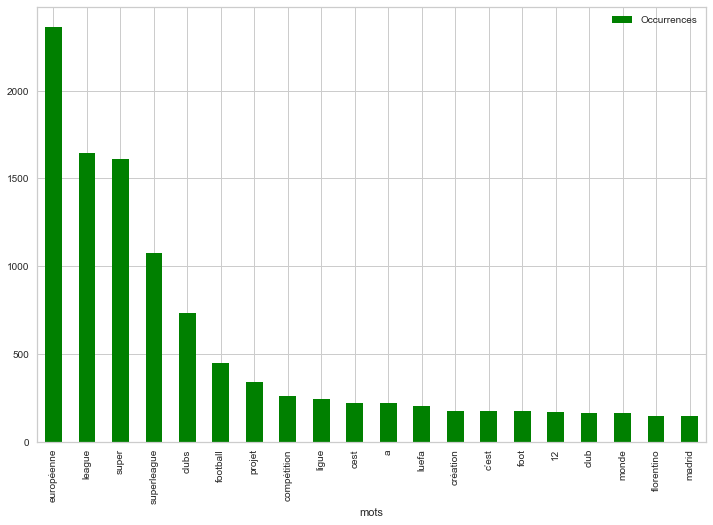

In [21]:
df1.head(20).plot(kind = "bar", figsize=(12, 8), color = "Green");

### 3.2 <span style="color:black"> Bigrams & Trigrams</span>

In [22]:
corpus = df['tweet_clean'].str.split()

In [23]:
# bigrammes dans un document
print(f"Notre document n° 99: {corpus[99]} \n")


print(f"La liste des bigrammes présents dans le document n°99 : {list(nltk.bigrams(corpus[99]))}")
print("")
print(f"La liste des Trigrammes présents dans le document n°99 : {list(nltk.trigrams(corpus[99]))}")

Notre document n° 99: ['officiel', '12', 'clubs', 'super', 'league', 'européenne', 'manutd', 'don', 'collectif', '15', 'millions', 'deuros', 'bonnes', 'causes', 'perdront', '5', 'recettes', 'compétitions', 'luefa', 'saison', 'prochaine', 'dinterdiction', 'compétition', 'mufc'] 

La liste des bigrammes présents dans le document n°99 : [('officiel', '12'), ('12', 'clubs'), ('clubs', 'super'), ('super', 'league'), ('league', 'européenne'), ('européenne', 'manutd'), ('manutd', 'don'), ('don', 'collectif'), ('collectif', '15'), ('15', 'millions'), ('millions', 'deuros'), ('deuros', 'bonnes'), ('bonnes', 'causes'), ('causes', 'perdront'), ('perdront', '5'), ('5', 'recettes'), ('recettes', 'compétitions'), ('compétitions', 'luefa'), ('luefa', 'saison'), ('saison', 'prochaine'), ('prochaine', 'dinterdiction'), ('dinterdiction', 'compétition'), ('compétition', 'mufc')]

La liste des Trigrammes présents dans le document n°99 : [('officiel', '12', 'clubs'), ('12', 'clubs', 'super'), ('clubs', 'su

### 3.3 <span style="color:black"> Nuages de mots </span>

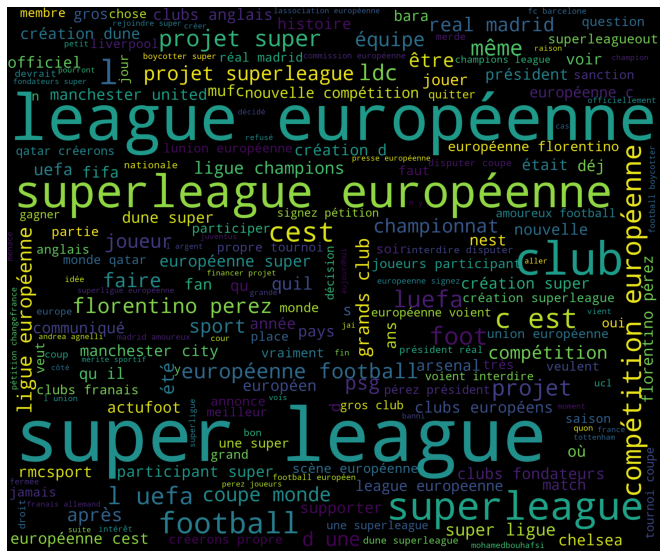

In [24]:
wordcloud = WordCloud(width = 1200,height = 1000,scale = 2, background_color='black',collocations=True).generate(' '.join(df["tweet_clean"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 4. <span style="color:Orange">  Classification non supervisée </span>

[![Unsupervised.png](https://i.postimg.cc/TYBv1nJ3/Unsupervised.png)](https://postimg.cc/svPN0QLk)

**Clustering**  : c'est une méthode de regroupement des objets en groupes de telle sorte que ceux qui présentent le plus de similitudes restent dans un groupe et présentent moins ou pas de similitudes avec les objets d'un autre groupe. L'analyse de cluster trouve les points communs entre les objets de données et les catégorise selon la présence et l'absence de ces points communs.

**Association**: Une règle d'association est une méthode d'apprentissage non supervisée qui est utilisée pour trouver les relations entre les variables dans une base de données. Il détermine l'ensemble des éléments qui se produisent ensemble dans l'ensemble de données. La règle d'association peut rendre une stratégie marketing plus efficace. Comme les personnes qui achètent un article X (supposons un pain) ont également tendance à acheter un article Y (beurre/confiture). Un exemple typique de règle d'association est l'analyse du panier de marché.

[![Scikit-learn-logo-small.png](https://i.postimg.cc/xTGTfcqV/Scikit-learn-logo-small.png)](https://postimg.cc/ykdzn6FL)

### 4.1 <span style="color:black">  K-means Clustering</span>

####  4.1.1 <span style="color:black">  TF-IDF</span>

Le ratio TF-IDF (Term-Frequency - Inverse Document Frequency) permet de pondérer la fréquence des tokens (mots dans notre corpus) dans un document par son importance relative dans les autres documents.

Ce score tient donc compte de la composition de notre corpus.

In [25]:
#Vectorisation des bigram et avec un minimum d'apparitions de 2 fois
vectorizer = TfidfVectorizer(ngram_range=range(1,3), min_df=2,stop_words=stopWords)
X = vectorizer.fit_transform(df['tweet_clean'])

print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
pd.DataFrame(vectorizer.get_feature_names()).sample(10)

,0
3645,nabildjellit
1414,dncg
1538,démissionné poste
4854,serai
3675,nations supercoupe
4332,prête
3869,pandémie
489,ballon
4864,signer
4760,sachant


####  4.1.2 <span style="color:black">  Choix du nombre de clusters `true_k` avec la méthode "elbow"</span>

Le choix du true_k se fera graphiquement en prenant l'abcisse du coude correspondant à une faible pente du graph.

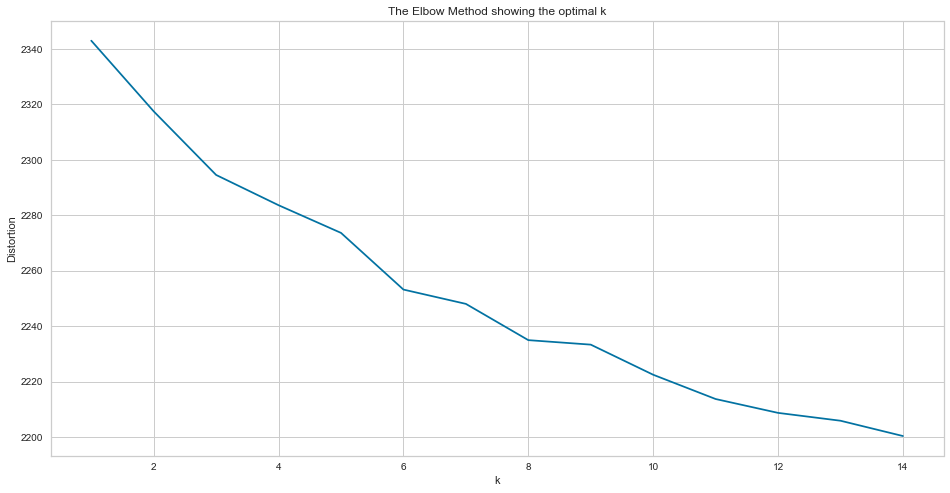

In [27]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

####  4.1.3 <span style="color:black">  Application de l'algorithme K-means</span>

In [28]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X)

print("Top termes par cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % (terms[ind])),
    print

print("\n")

Top termes par cluster:
Cluster 0:
 coupe monde
 coupe
 monde
 florentino
 amoureux football
 football boycotter
 boycotter super
 europeenne signez
 madrid amoureux
 amoureux
Cluster 1:
 league européenne
 league
 super league
 super
 européenne
 football
 projet
 projet super
 foot
 clubs
Cluster 2:
 superleague européenne
 superleague
 européenne
 projet superleague
 projet
 clubs
 football
 création
 création superleague
 foot
Cluster 3:
 manchester
 united
 city
 manchester united
 manchester city
 milan
 arsenal
 madrid
 chelsea
 league européenne
Cluster 4:
 clubs
 superleague
 européenne
 compétition
 compétition européenne
 super
 league
 ligue
 super league
 uefa




####  4.1.4 <span style="color:black">  Test de prédiction du cluster</span>

In [29]:
print("\n")
print("Prediction")
X = vectorizer.transform(["qui est la banque qui finance cette proposition"])
predicted = model.predict(X)
print(predicted)



Prediction
[4]


####  4.1.5 <span style="color:black">  Visualisation de la distance interclusters</span>

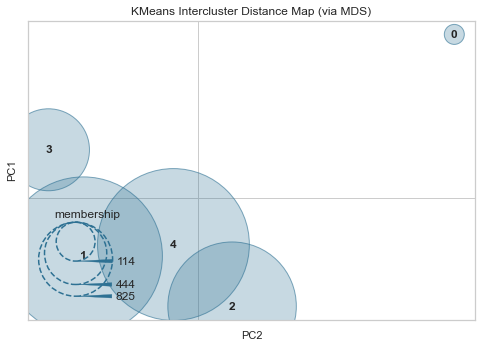

In [30]:
visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show();

### 4.2 <span style="color:black">  Topic Modelling (LatentDirichletAllocation)</span>

####  4.2.1 <span style="color:black">  Vectorisation & Transformation </span>

In [31]:
#Filtre appliqué sur les mots qui apparaissent dans moins de 10% des tweets 
vectorizer = CountVectorizer(min_df=25,stop_words=stopWords, token_pattern=r'\w+|\$[\d\.]+|\S+n')

In [32]:
tf = vectorizer.fit_transform(df['tweet_clean']).toarray()

In [33]:
tf_feature_names = vectorizer.get_feature_names()

####  4.2.2 <span style="color:black">  Modélisation </span>

In [34]:
#Choix de nombre de topics arbitraire
number_of_topics = 6

model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2.fit(tf)

LatentDirichletAllocation(n_components=6, random_state=0)

In [35]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [36]:
no_top_words = 10
display_topics(model2, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,européenne,118.9,super,452.4,superleague,328.6,clubs,233.1,superleague,667.1,league,1073.6
1,madrid,113.0,football,444.8,européenne,312.5,monde,143.9,européenne,614.0,super,1027.8
2,real,102.2,league,442.6,clubs,274.4,européenne,133.5,cest,183.5,européenne,810.6
3,manchester,96.2,européenne,373.5,création,162.3,coupe,121.2,ligue,111.8,clubs,139.3
4,arsenal,93.2,projet,102.9,uefa,159.5,joueurs,110.3,foot,87.9,projet,80.5
5,super,80.9,nouvelle,58.9,12,110.9,perez,73.1,compétition,86.6,foot,78.6
6,league,80.4,florentino,52.3,’un,104.8,franais,61.2,projet,81.1,luefa,75.1
7,liverpool,79.2,président,50.9,dune,67.9,florentino,60.5,même,75.9,compétition,63.5
8,city,73.2,pérez,49.2,compétition,56.2,3,56.4,être,72.5,fifa,61.9
9,milan,65.2,ligue,47.7,psg,55.1,super,54.2,superligue,58.2,club,59.2


Sans trop de surprises, les termes ayant le plus de poids (occurences) dans les tweets sont :
- super league européenne
- UEFA / FIFA
- 12 clubs fondateurs de l'ESL
- Florentino Perez le président du Réal Madrid par celui l'annonce est venue
- PSG / Real / Manchester U/ Manchester City/ Arsenal / Milan : qui sont les clubs protagonistes ou antagonistes du projet

### 4.3 <span style="color:black">  Topic Modelling (Non-Negative Matrix Factorization)</span>

####  4.3.1 <span style="color:black">  Vectorisation & Transformation </span>

In [37]:
D = TfidfVectorizer(min_df=25, stop_words=stopWords)
# Fit and transform
F = D.fit_transform(df.tweet_clean)

####  4.3.2 <span style="color:black">  Modélisation </span>

In [38]:
model3 = NMF(n_components=5, random_state=5, init='nndsvda')
model3.fit(F)
nmf_features = model3.transform(F)

In [39]:
components_df = pd.DataFrame(model3.components_, columns=D.get_feature_names())

####  4.3.3 <span style="color:black"> Top5 des Topics obtenus </span>

In [40]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'les mots les plus récurrents du topic {topic} :')
    print(tmp.nlargest(5))
    print('\n')

les mots les plus récurrents du topic 0 :
league        3.188154
super         3.118565
européenne    2.032661
création      0.178814
foot          0.169846
Name: 0, dtype: float64


les mots les plus récurrents du topic 1 :
superleague    2.979302
européenne     1.491410
ligue          0.190904
compétition    0.187572
création       0.174235
Name: 1, dtype: float64


les mots les plus récurrents du topic 2 :
clubs          2.410728
12             0.817913
compétition    0.657415
uefa           0.540495
luefa          0.540132
Name: 2, dtype: float64


les mots les plus récurrents du topic 3 :
football      2.936123
président     0.249230
monde         0.219460
sport         0.199163
florentino    0.178757
Name: 3, dtype: float64


les mots les plus récurrents du topic 4 :
projet      2.584441
foot        0.727257
ligue       0.345292
banque      0.263618
jpmorgan    0.197743
Name: 4, dtype: float64




[![1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png](https://i.postimg.cc/XqkSbBL2/1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png)](https://postimg.cc/tnJmdTLP)

### 4.4 <span style="color:black">  Topic Modelling (LDA) </span>

- **Conversion en liste**

In [41]:
#Conversion en liste
tweet_list = df['tweet_clean'].to_list()

- **Création des bigram & Trigram**

In [42]:
bigram = gensim.models.Phrases(tweet_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_list], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

- **Reprocessing : Lemmatisation / Tokenisation & Suppression des stop words**

In [43]:
def process_words(texts, stop_words=stopWords):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    return texts

In [44]:
tweet_ready = process_words([tweet_list])  # Liste des tweets

In [45]:
tweet_dict = corpora.Dictionary(tweet_ready)

#tweet_dict.filter_extremes(no_below=2, no_above=.99) #Filtre pour les valeurs extrêmes

# Creation du corpus
corpus = [tweet_dict.doc2bow(text) for text in tweet_ready]

# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=10, 
                                           random_state=100)


pprint(ldamodel.print_topics())

[(0,
  '0.041*"league" + 0.037*"européenne" + 0.035*"super" + 0.019*"superleague" + '
  '0.019*"clubs" + 0.009*"football" + 0.006*"ligue" + 0.006*"projet" + '
  '0.006*"luefa" + 0.005*"cest"'),
 (1,
  '0.053*"européenne" + 0.036*"league" + 0.035*"super" + 0.027*"superleague" + '
  '0.022*"clubs" + 0.012*"projet" + 0.009*"football" + 0.008*"compétition" + '
  '0.005*"ligue" + 0.005*"création"'),
 (2,
  '0.014*"européenne" + 0.010*"super" + 0.010*"superleague" + 0.010*"league" + '
  '0.007*"clubs" + 0.005*"football" + 0.003*"projet" + 0.003*"compétition" + '
  '0.003*"ligue" + 0.003*"uefa"'),
 (3,
  '0.028*"européenne" + 0.018*"league" + 0.015*"super" + 0.010*"superleague" + '
  '0.009*"clubs" + 0.007*"football" + 0.005*"projet" + 0.004*"compétition" + '
  '0.004*"ligue" + 0.003*"cest"'),
 (4,
  '0.048*"européenne" + 0.040*"league" + 0.033*"super" + 0.025*"superleague" + '
  '0.013*"clubs" + 0.012*"football" + 0.009*"projet" + 0.008*"compétition" + '
  '0.005*"luefa" + 0.005*"cest"'),
 (

#### 4.4.1 Cohérance & Perplexité

- Cohérance : Les mesures de cohérence des topics évaluent un seul Topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce même topic. Ces mesures permettent de distinguer les topics qui sont sémantiquement interprétables des autres topics qui sont des artefacts d'inférence statistique.

 - Perplexité: est une mesure statistique de la capacité d'un modèle de probabilité à prédire un échantillon.

In [46]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -8.161428556771595

Coherence Score:  0.2449924333750199


#### 4.4.2 Tunning des hyperparamètres du modèle

- #### 4.4.2.1 Perplexité

 - Remarque : Une perplexité négative est principalement dûe au log_perplexity qui génère le log de la probabilité

 -  Plus la perplexité est elevée plus le modèle prédit mieux.

In [ ]:
def plot_perplexity(dict_, corpus):
    num_topics_range = range(2, 20)
    perplexities = []
    for num_topics in num_topics_range:
        lda_model = ldamodel
        perplexities.append(lda_model.log_perplexity(corpus))
    plt.plot(num_topics_range, perplexities, color='blue', marker='o', markersize=5)
    plt.title('Log perplexité en fonction des nombres des topics')
    plt.xlabel('Nombre de topics')
    plt.ylabel('Log perplexité')
    plt.grid()
    plt.show()

In [ ]:
number_topics = 15
plot_perplexity(tweet_dict, corpus)

- #### 4.4.2.2 Cohérance

 - La cohérance varie généralement de 0.3 (bas) --> 0.6(bon) --> 0.9 ~ 1 (faux)
 - La cohérance peut être améliorée par le choix des topics, le changement des coefficients alpha ou beta

In [47]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    ldamodel = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=tweet_ready, dictionary=tweet_dict, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

- Résultat du tunning:

In [51]:
df_result=pd.read_csv('lda_tuning_results.csv')

In [52]:
df_result.sort_values(["Coherence"], axis=0, ascending=False, inplace=True) 
df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
388,100% Corpus,5,asymmetric,0.9099999999999999,0.502472
533,100% Corpus,10,symmetric,0.9099999999999999,0.500089
513,100% Corpus,10,0.01,0.9099999999999999,0.488323
488,100% Corpus,9,0.31,0.9099999999999999,0.487897
298,100% Corpus,2,asymmetric,0.9099999999999999,0.486332
518,100% Corpus,10,0.31,0.9099999999999999,0.477772
487,100% Corpus,9,0.31,0.61,0.473631
417,100% Corpus,6,asymmetric,0.61,0.472196
477,100% Corpus,8,asymmetric,0.61,0.466220
58,75% Corpus,3,asymmetric,0.9099999999999999,0.463794


- #### 4.4.2.3 Modèle amélioré

In [53]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           iterations=100,
                                           eta=0.9)


pprint(ldamodel.print_topics()) 

[(0,
  '0.001*"league" + 0.001*"européenne" + 0.001*"super" + 0.000*"superleague" + '
  '0.000*"clubs" + 0.000*"football" + 0.000*"ligue" + 0.000*"cest" + '
  '0.000*"uefa" + 0.000*"luefa"'),
 (1,
  '0.059*"européenne" + 0.041*"league" + 0.040*"super" + 0.027*"superleague" + '
  '0.018*"clubs" + 0.011*"football" + 0.008*"projet" + 0.006*"compétition" + '
  '0.006*"ligue" + 0.006*"cest"'),
 (2,
  '0.000*"européenne" + 0.000*"super" + 0.000*"league" + 0.000*"superleague" + '
  '0.000*"clubs" + 0.000*"football" + 0.000*"ligue" + 0.000*"uefa" + '
  '0.000*"compétition" + 0.000*"projet"'),
 (3,
  '0.000*"européenne" + 0.000*"league" + 0.000*"super" + 0.000*"superleague" + '
  '0.000*"clubs" + 0.000*"football" + 0.000*"ligue" + 0.000*"projet" + '
  '0.000*"compétition" + 0.000*"cest"'),
 (4,
  '0.001*"européenne" + 0.001*"league" + 0.001*"super" + 0.001*"superleague" + '
  '0.000*"football" + 0.000*"clubs" + 0.000*"projet" + 0.000*"compétition" + '
  '0.000*"cest" + 0.000*"ligue"')]


In [54]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.1226085382768

Coherence Score:  0.24629694140505815


- #### 4.4.2.4 Visualisation des topics obtenus

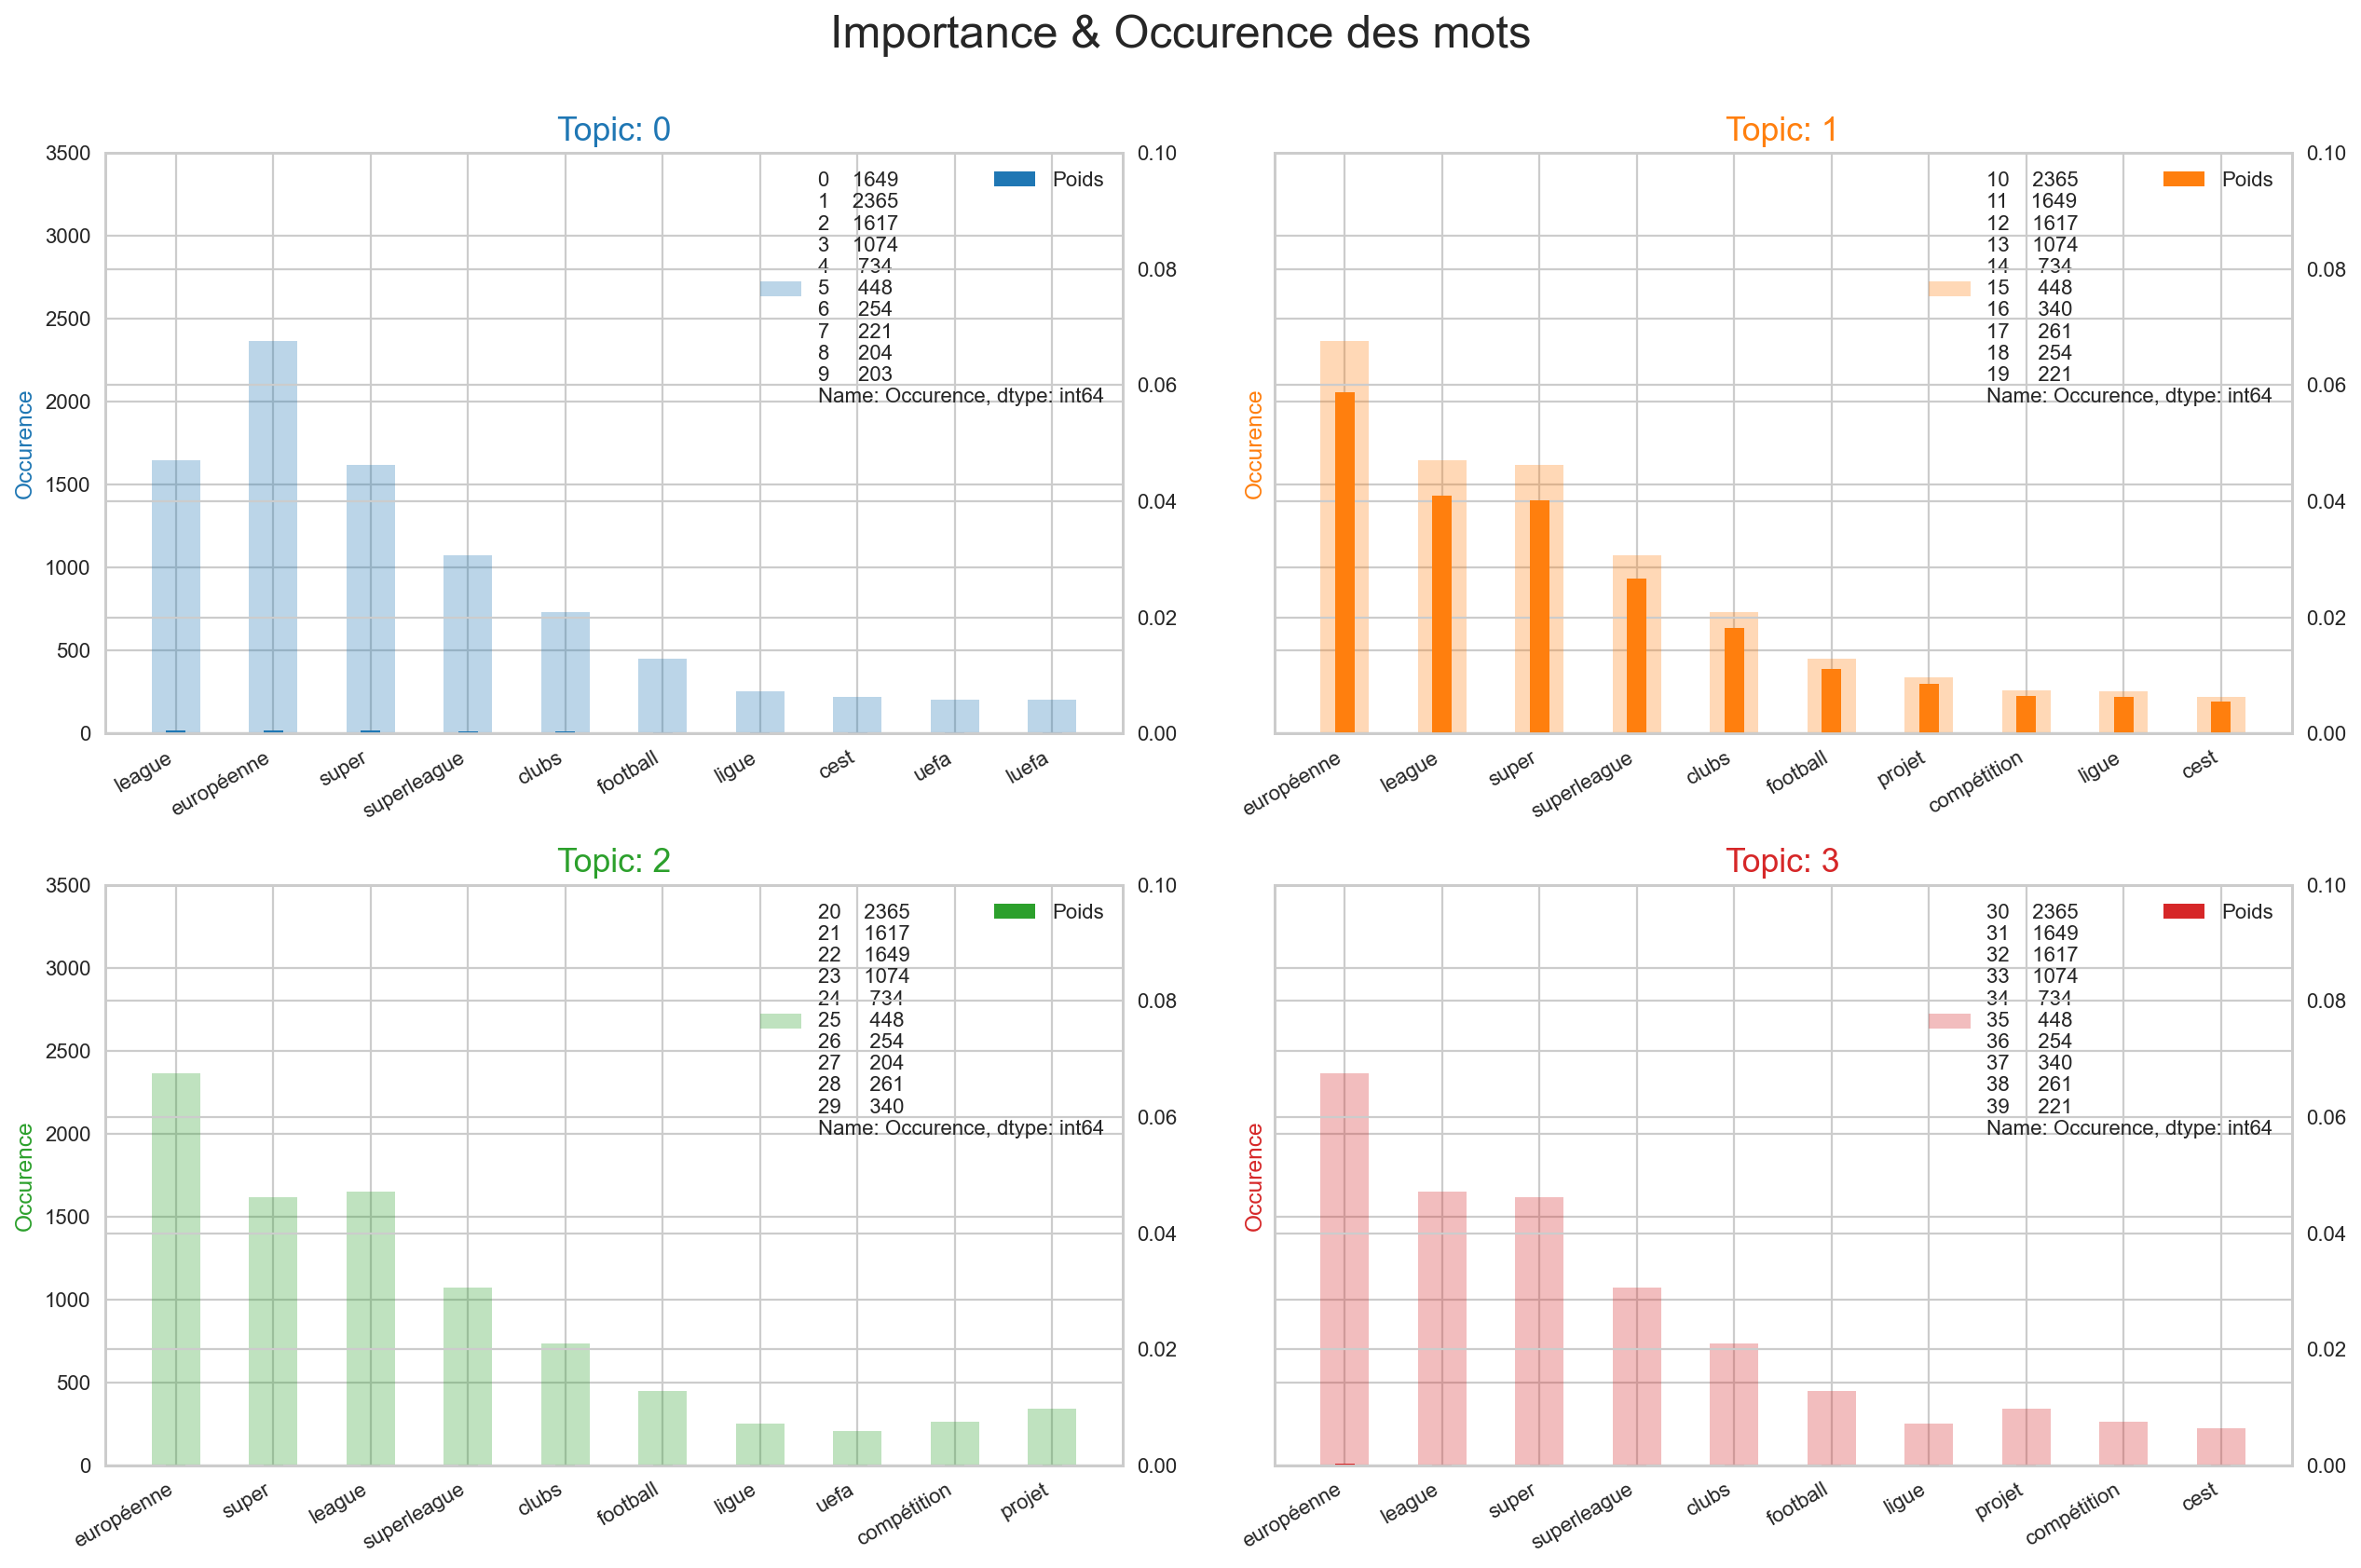

In [55]:
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in tweet_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['Mot', 'topic_id', 'importance', 'Occurence'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Mot', height="Occurence", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Occurence')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Mot', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Poids')
    ax.set_ylabel('Occurence', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(df.loc[df.topic_id==i, 'Mot'])
    ax.set_xticklabels(df.loc[df.topic_id==i, 'Mot'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='best'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)    
fig.suptitle('Importance & Occurence des mots', fontsize=22, y=1.05)    
plt.show()

In [56]:
pyLDAvis.enable_notebook()
gensim_dictionary = tweet_dict
gensim_corpus = corpus
lda_model = ldamodel


lda_visualization = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### 4.5 <span style="color:black">  Topic Modelling (NMF) </span>

In [57]:
dictionary = Dictionary(tweet_ready)

corpus = [dictionary.doc2bow(text) for text in tweet_ready]

- **Création du bag of words avec un format : (list of(token_id, token_count))**

In [58]:
corpus = [dictionary.doc2bow(text) for text in tweet_ready]

In [59]:
nmf = Nmf(
    corpus=corpus,
    num_topics=10,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)
pprint(nmf.print_topics())

[(0,
  '0.069*"européenne" + 0.048*"league" + 0.047*"super" + 0.031*"superleague" + '
  '0.021*"clubs" + 0.013*"football" + 0.010*"projet" + 0.008*"compétition" + '
  '0.007*"ligue" + 0.006*"cest"'),
 (1,
  '0.069*"européenne" + 0.048*"league" + 0.047*"super" + 0.032*"superleague" + '
  '0.022*"clubs" + 0.013*"football" + 0.010*"projet" + 0.008*"compétition" + '
  '0.007*"ligue" + 0.006*"cest"'),
 (2,
  '0.069*"européenne" + 0.048*"league" + 0.047*"super" + 0.032*"superleague" + '
  '0.022*"clubs" + 0.013*"football" + 0.010*"projet" + 0.008*"compétition" + '
  '0.007*"ligue" + 0.006*"cest"'),
 (3,
  '0.001*"supplanter" + 0.001*"ici" + 0.001*"sauvages" + 0.001*"olympiakosfr" '
  '+ 0.001*"tape" + 0.001*"côtés" + 0.001*"marlène" + 0.001*"niang" + '
  '0.001*"remplacera" + 0.001*"supportez"'),
 (4,
  '0.069*"européenne" + 0.048*"league" + 0.047*"super" + 0.032*"superleague" + '
  '0.022*"clubs" + 0.013*"football" + 0.010*"projet" + 0.008*"compétition" + '
  '0.007*"ligue" + 0.006*"cest"')

- #### 4.5.1 Cohérance

In [60]:
coherence_model_nmf = CoherenceModel(
        model=nmf,
        texts=tweet_ready,
        dictionary=dictionary,
        coherence='c_v')
    
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence Score:  0.4131594935298448
